[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/simframe/HEAD?labpath=examples%2Fexample_nbody.ipynb)

# Example: N-body problem

In this notebook we are setting up an [N-body problem](https://en.wikipedia.org/wiki/N-body_problem), the gravitational interaction of more than 2 bodies. Here we are going to model $N$ solar mass stars that interact gravitationally.

The number of stars is adjustable and can be set in the following variable

In [1]:
N = 5

First, we define a few constants that are needed for the simulation in SI units.

In [2]:
au    = 1.49597870700e11       # Astronomical unit [m]
day   = 24. * 3600.            # Day [s]
G     = 6.6743e-11             # Gravitational constant [m³/kg/s²]
M_sun = 1.988409870698051e+30  # Solar mass [kg]

Next we are setting up the simulation frame.

In [3]:
from simframe import Frame

In [4]:
sim = Frame(description="N-body problem")

We store all $N$ bodies in a group.

In [5]:
sim.addgroup("bodies", description="Gravitationally interacting bodies")

The bodies get their subgroup within this group to store their parameters.

In [6]:
import numpy as np

In [7]:
for i in range(N):
    # Adding a new group for each body
    ndigits = int(np.ceil(np.log10(N)))
    name = "body" + f"{i}".zfill(ndigits)
    sim.bodies.addgroup(name)

In [8]:
sim.bodies

Group (Gravitationally interacting bodies)
------------------------------------------
    body0        : Group
    body1        : Group
    body2        : Group
    body3        : Group
    body4        : Group
  -----

All bodies will have the same mass of $M_\odot$. Their initial positions are randomly picked in a cube of length $1\,\mathrm{au}$ centered on $0$. In this step their velocities are initialized with a rendom vector of length $1$.

In [9]:
# Iteration over all bodies
for _, body in sim.bodies:
    # Initialization of the mass
    body.addfield("M", M_sun, description="Mass [kg]")
    # Initialization of the position in [-0.5, 0.5) au
    r = (np.random.rand(3)-0.5) * au
    body.addfield("r", r, description="Position [m]")
    # Initialize velocity with random unit vector
    v = np.random.rand(3)-0.5
    v /= np.linalg.norm(v)
    body.addfield("v", v, description="Velocity [m/s]")

We want to initialize the velocities in a way that the entire system is gravitationally bound. For this we utilize the [virial theorem](https://en.wikipedia.org/wiki/Virial_theorem) which states

$\Large 2T + U = 0$

for a gravitationally bound system, where $T$ is the total kinetic energy and $U$ the total potential energy. If all bodies have the same mass $M$ and velocity $\bar{v}$ then the total kinetic energy can be written as

$\Large T = \frac{N}{2}M\bar{v}^2$,

from which we can get the average velocity as

$\Large \bar{v} = \sqrt{-\frac{U}{NM}}$.

We initialize all bodies with this velocity.

We can get the total potential energy by adding up the energy it takes to remove all bodies one by one from the system to infinity

$\Large U = -\sum\limits_{i=1}^N \sum\limits_{j=i+1}^N G\frac{M_iM_j}{\Delta R_{ij}}$,

with the distance $\Delta R_{ij}$ between body $i$ and $j$.

Here we create helper functions to compute $T$ and $U$ to set the correct value of $\bar{v}$. They can also be used later to check energy conservation.

In [10]:
def get_T(data):
    T = 0.
    for _, body in data.bodies:
        T += 0.5*body.M*np.linalg.norm(body.v, axis=-1)**2
    return T

In [11]:
def get_U(data):
    U = 0.
    for i, (_, body) in enumerate(data.bodies):
        for j, (_, other) in enumerate(data.bodies):
            if i>=j: continue
            U -= G*body.M*other.M/np.linalg.norm(body.r-other.r, axis=-1)
    return U

With these helper functions we compute the initial potential energy and from that the initial velocities of the bodies in virial equilibrium.

In [12]:
vbar = np.sqrt(-get_U(sim)/(N*M_sun))

We assign this velocity to all bodies, while keeping their random direction.

In [13]:
for _, body in sim.bodies:
    body.v *= vbar

Now we have to set up the differential equations for positions and velocities. The derivative of the position is simply the velocity.

In [14]:
def drdt(sim, *args, body, **kwargs):
    return body.v

This function can be assigned to the differentiator of the respective body. `functools.partial` is returning a new function with a set keyword argument. In this way a generalized function can be used for all bodies.

In [15]:
from functools import partial

In [16]:
for _, body in sim.bodies:
    body.r.differentiator = partial(drdt, body=body)

The derivative of the velocity is the acceleration due to the gravitation of the other bodies. We have to write a helper function for this which is computing the gravitational acceleration due to a single body.

In [17]:
def ag(r_self, r_other, M_other):
    direction = r_self - r_other
    distance = np.linalg.norm(direction) + 1.e-3*au # Adding a smoothing length to avoid division by zero in collisions
    return - G * M_other * direction / distance**3

With this helper function we can write a function for the derivative of a body's velocity.

In [18]:
def dvdt(sim, *args, body, **kwargs):
    a = 0.
    for _, other in sim.bodies:
        if other == body: continue  # Skip if other body is the body itself
        a += ag(body.r, other.r, other.M)
    return a

This function is assigned to the differentiators of the velocities.

In [19]:
for _, body in sim.bodies:
    body.v.differentiator = partial(dvdt, body=body)

In the next step we have to set up the integration variable for the time an initialize it with $0$.

In [20]:
sim.addintegrationvariable("t", 0., description="Time [s]")

We also need a function that is computing the maximum time step, we can take. The smaller this time step the better energy will be conserved, but the longer the simulation will run. To compromised between runtime and accuracy we allow the fastest body to travel at most $5\,\%$ of the closest distance between two bodies.

In [21]:
from itertools import combinations

In [22]:
def dt(sim):
    r = []
    vmax = 0.
    for _, body in sim.bodies:
        # Store all position vectors 
        r.append(body.r)
        # Value of velocity. Store if larger.
        v = np.linalg.norm(body.v)
        if v > vmax:
            vmax = v
    # Get all possible combinations of position vectors to find the smallest distance
    combs = combinations(r, 2)
    dmin = np.min([np.linalg.norm(body1-body2) for (body1, body2) in combs])
    return 0.05 * dmin/vmax

This function is assigned to the updater of the integration variable.

In [23]:
sim.t.updater = dt

We furthermore set up the snapshots at which an output is written and the maximum simulation time.

In [24]:
stepsize = 0.2 * day
t_max = 100. * day

In [25]:
sim.t.snapshots = np.linspace(sim.t, t_max, num=int((t_max-sim.t)/stepsize))

The simulation frame now looks as follows.

In [26]:
sim.toc

Frame (N-body problem)
    - bodies: Group (Gravitationally interacting bodies)
        - body0: Group
            - M: Field (Mass [kg])
            - r: Field (Position [m])
            - v: Field (Velocity [m/s])
        - body1: Group
            - M: Field (Mass [kg])
            - r: Field (Position [m])
            - v: Field (Velocity [m/s])
        - body2: Group
            - M: Field (Mass [kg])
            - r: Field (Position [m])
            - v: Field (Velocity [m/s])
        - body3: Group
            - M: Field (Mass [kg])
            - r: Field (Position [m])
            - v: Field (Velocity [m/s])
        - body4: Group
            - M: Field (Mass [kg])
            - r: Field (Position [m])
            - v: Field (Velocity [m/s])
    - t: IntVar (Time [s]), Integration variable


In the next step we need to set up the integrator and the integration instructions.

In [27]:
from simframe import Integrator

We first initialize the integrator with the integration variable.

In [28]:
sim.integrator = Integrator(sim.t)

Then we are setting up leap frog integration for every body separately as introduced in an earlier chapter, in which updates of position and velocity are alternating.

In [29]:
from simframe import Instruction
from simframe import schemes

Here we are using the explicit 1st order Euler scheme. But higher order scheme like Runge-Kutta would be possible as well.

In [30]:
scheme = schemes.expl_1_euler

In [31]:
# First half step of positions
for name, body in sim.bodies:
    sim.integrator.instructions.append(Instruction(scheme, body.r, fstep=0.5, description=f"{name:<7}: r first half step"))
# Update of positions
for name, body in sim.bodies:
    sim.integrator.instructions.append(Instruction(schemes.update, body.r, description=f"{name:<7}: r update"))
# Full step of velocities
for name, body in sim.bodies:
    sim.integrator.instructions.append(Instruction(scheme, body.v, fstep=1.0, description=f"{name:<7}: v full step"))
# Update of velocities
for name, body in sim.bodies:
    sim.integrator.instructions.append(Instruction(schemes.update, body.v, description=f"{name:<7}: v update"))
# Second half step of velocities
for name, body in sim.bodies:
    sim.integrator.instructions.append(Instruction(scheme, body.r, fstep=0.5, description=f"{name:<7}: r second half step"))

The integration instruction set now look as follows.

In [32]:
sim.integrator.instructions

[Instruction (body0  : r first half step),
 Instruction (body1  : r first half step),
 Instruction (body2  : r first half step),
 Instruction (body3  : r first half step),
 Instruction (body4  : r first half step),
 Instruction (body0  : r update),
 Instruction (body1  : r update),
 Instruction (body2  : r update),
 Instruction (body3  : r update),
 Instruction (body4  : r update),
 Instruction (body0  : v full step),
 Instruction (body1  : v full step),
 Instruction (body2  : v full step),
 Instruction (body3  : v full step),
 Instruction (body4  : v full step),
 Instruction (body0  : v update),
 Instruction (body1  : v update),
 Instruction (body2  : v update),
 Instruction (body3  : v update),
 Instruction (body4  : v update),
 Instruction (body0  : r second half step),
 Instruction (body1  : r second half step),
 Instruction (body2  : r second half step),
 Instruction (body3  : r second half step),
 Instruction (body4  : r second half step)]

Finally we are using the namespace writer to save the outputs in the simulation frame itself.

In [33]:
from simframe import writers

In [34]:
sim.writer = writers.namespacewriter
sim.writer.verbosity = 0

The simulation frame is now ready to go

In [35]:
sim

Frame (N-body problem)
----------------------
    bodies       : Group (Gravitationally interacting bodies)
  -----
    t            : IntVar (Time [s]), Integration variable
  -----
    Integrator   : Integrator
    Writer       : Writer (Temporary namespace writer)

and we can run the simulation.

In [36]:
sim.run()

Execution time: 0:00:08


To analyze the orbits we read in the data.

In [37]:
data = sim.writer.read.all()

We are going to transform the data into an animation. In the first step we are plotting the initial conditions. The plot shall be centered on the center of mass and all bodies should be visible in a square field of view. For this we are writing a helper function that takes the positions as input and returns the axis limits.

In [38]:
def get_lim(r, m, f=1.5):
    # Center of mass coordinates
    com = np.average(r, weights=m.squeeze(), axis=0)
    # Distances of bodies to center of mass
    dist = np.abs(com-r)
    # The maximum distance of a body to the center of mass in x- and y-direction multiplied with a factor f
    length = f*np.maximum(dist[:, 0].max(), dist[:, 1].max())
    # Returning the axis limits in x and y
    xmin, xmax = com[0]-length, com[0]+length
    ymin, ymax = com[1]-length, com[1]+length
    return (xmin, xmax), (ymin, ymax)

In [39]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

Plot of the initial conditions to set up the figure

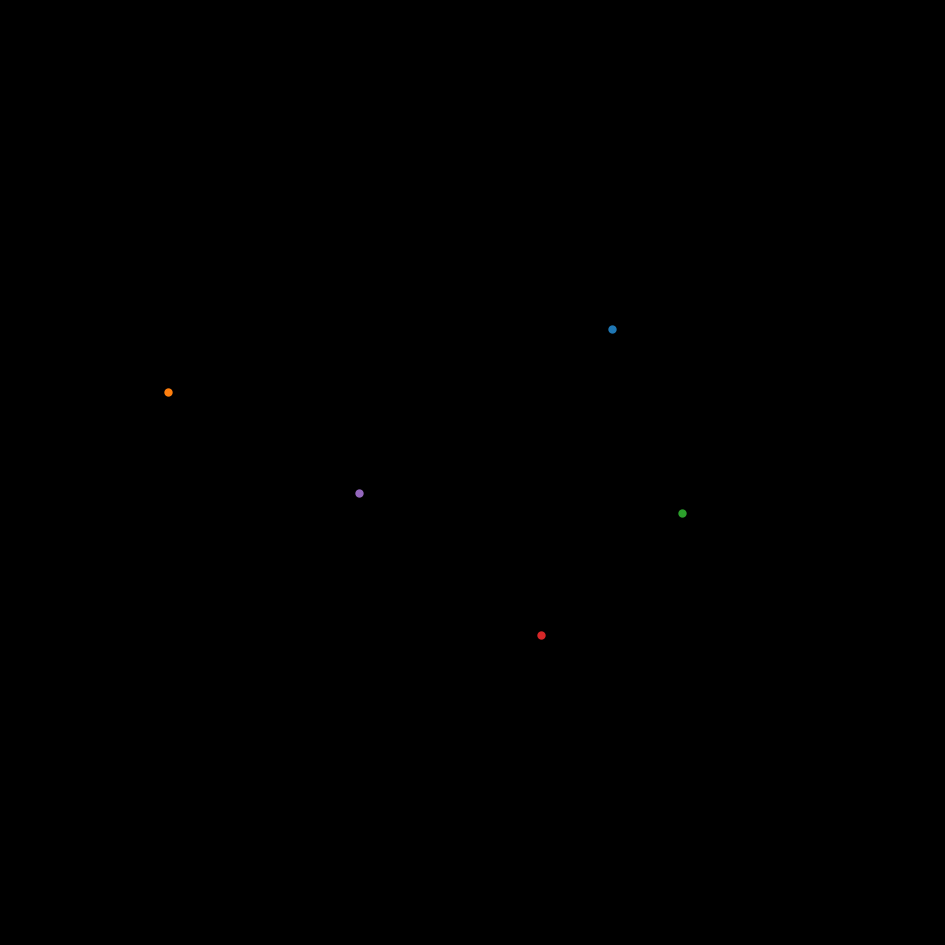

In [40]:
fig, ax = plt.subplots(figsize=(6.4, 6.4))
ax.set_aspect(1)
fig.set_facecolor("black")
ax.axis("off")
bodies = {}
traces = {}
r = []
m = []
for name, body in data.bodies.__dict__.items():
    r.append(body.r[0, :])
    m.append(body.M[0])
    traces[name], = ax.plot(body.r[0:1, 0], body.r[0:1, 1], lw=1, alpha=0.33)
    bodies[name], = ax.plot(body.r[0, 0], body.r[0, 1], ".", c=traces[name].get_c())
lim = get_lim(np.array(r), np.array(m))
ax.set_xlim(lim[0][0], lim[0][1])
ax.set_ylim(lim[1][0], lim[1][1])
fig.tight_layout()

In [41]:
def animate(i):
    ret = []
    r = []
    m = []
    for name, body in data.bodies.__dict__.items():
        r.append(body.r[i, :])
        m.append(body.M[i])
        traces[name].set_data([body.r[:i+1, 0]], [body.r[:i+1, 1]])
        bodies[name].set_data([body.r[i, 0]], [body.r[i, 1]])
        ret.append(traces[name])
        ret.append(bodies[name])
    lim = get_lim(np.array(r), np.array(m))
    ax.set_xlim(lim[0][0], lim[0][1])
    ax.set_ylim(lim[1][0], lim[1][1])
    return ret

In [42]:
from matplotlib import animation
from IPython.display import HTML
import re

In [43]:
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=sim.t.snapshots.shape[0],
    blit=True,
    interval=30,
)

In [44]:
HTML(re.sub('width="\d*" height="\d*"', 'width="100%"', anim.to_html5_video()))

We can furthermore check for energy and angular momentum conservation. For energy we can re-use the functions we defined earlier. First, we plot the relative energy deviation.

In [45]:
U = get_U(data)
T = get_T(data)

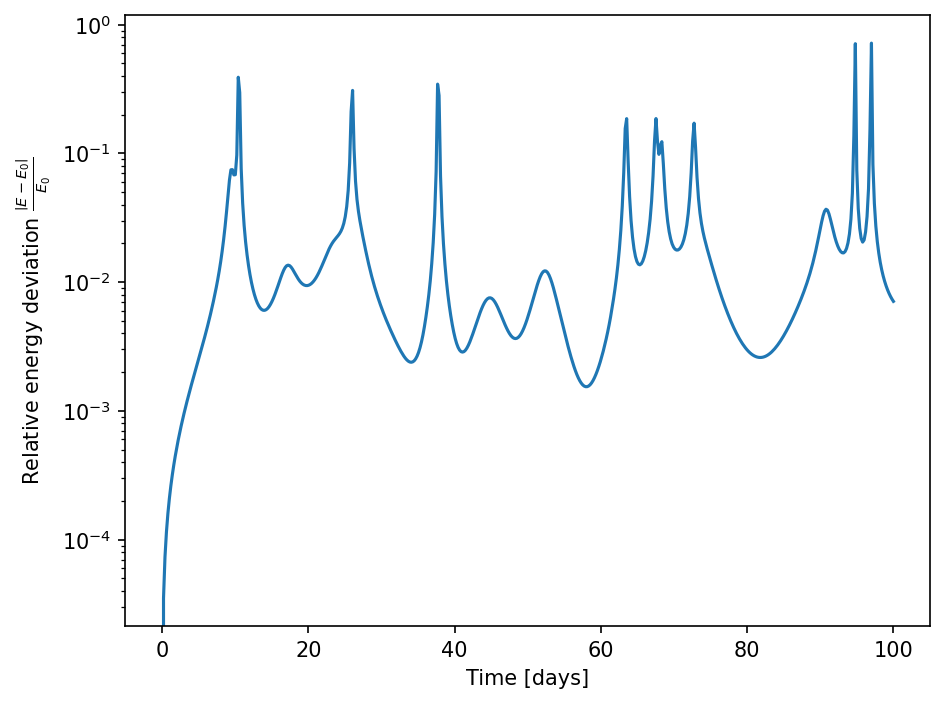

In [46]:
fig, ax = plt.subplots()
E0 = (T+U)[0]
ax.plot(data.t/day, np.abs((T+U-E0)/E0))
ax.set_xlabel("Time [days]")
ax.set_ylabel(r"Relative energy deviation $\frac{\left| E-E_0 \right|}{E_0}$")
ax.set_yscale("log")
fig.tight_layout()

By comparison with the animation it can be seen that there is a problem with energy conservation in close encounters between the bodies. This could be improved by going to higher order integration schemes and/or by reducing the time step in close encounters. Specialized N-body solvers like [Rebound](https://rebound.readthedocs.io/en/latest/), therefore, have special treatments for close encounters.

We can also check on the conservation of angular momentum. We, therefore, write a function that is adding up the angular momentum of every body with respect to the center of mass.

In [47]:
def get_L(data):
    # Get arrays of mass, position, and velocity of all bodies.
    m, r, v = [], [], []
    for _, body in data.bodies:
        m.append(body.M)
        r.append(body.r)
        v.append(body.v)
    m, r, v = np.array(m), np.array(r), np.array(v)
    # Computing center of mass
    com = np.average(r, weights=m[:, 0], axis=0)
    # Adding up the angular momenta
    L = 0.
    for _, body in data.bodies:
        L += body.M[:, None] * np.cross(com-body.r, body.v)
    # Returning the absolute values of the total angular momentum
    return np.linalg.norm(L, axis=-1)

In [48]:
L = get_L(data)

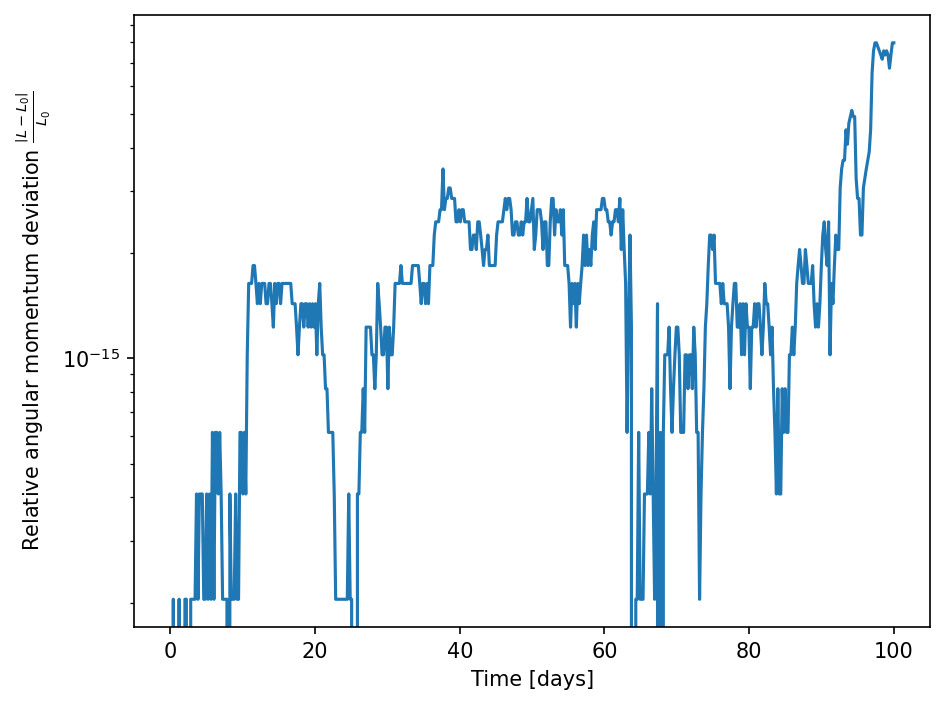

In [49]:
fig, ax = plt.subplots()
L0 = L[0]
ax.plot(data.t/day, np.abs((L-L0)/L0))
ax.set_xlabel("Time [days]")
ax.set_ylabel(r"Relative angular momentum deviation $\frac{\left| L - L_0 \right|}{L_0}$")
ax.set_yscale("log")
fig.tight_layout()

Here it can be seen that angular momentum is conserved up to machine precision, which is a property of the symplectic integrator used here.